In [1]:
#imprt the necessary calculations for everything we will use
import datetime
import time
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from netCDF4 import Dataset, num2date, date2num
import numpy as np
from scipy.ndimage import gaussian_filter
from shapely.geometry.polygon import LinearRing
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy.calc as mpcalc
import xlrd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats import linregress

In [2]:
#blue marble pathway
os.environ["CARTOPY_USER_BACKGROUNDS"] = '/Users/cjmasiel/Desktop/Cartopy/BG/'

In [10]:
#this is the function that creates the map background of the North Atlantic Domain
def create_map_background():
    dataproj = ccrs.PlateCarree()
    fig=plt.figure(figsize=(25, 25))
    ax=plt.subplot(111, projection=dataproj)
    ax.set_extent([-10, -105, 5, 50],ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=1.5)
    ax.add_feature(cfeature.STATES, linewidth=1.0)
    ax.add_feature(cfeature.BORDERS, linewidth=1.0)
    gl = ax.gridlines(color='gray',alpha=0.5,draw_labels=True)
    gl.xlabels_top, gl.ylabels_right = False, False
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 16}, {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([0,-10, -20,-30, -40,-50, -60,-70, -80,-90,-100,-110])
    gl.ylocator = mticker.FixedLocator([0, 10, 20, 30, 40, 50])
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)
    ###############################################################################################
    ax.background_img(name='BM', resolution='high')
    ###############################################################################################
    plt.scatter(-180,-40,alpha = 1.0, color = '#5ebaff', label = 'Tropical Depression')
    plt.scatter(-180,-40,alpha = 1.0, color='#00faf4', label = 'Tropical Storm')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffffcc', label = 'Category 1')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffe775', label = 'Category 2')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffc140', label = 'Category 3')
    plt.scatter(-180,-40,alpha = 1.0, color='#ff8f20', label = 'Category 4')
    plt.scatter(-180,-40,alpha = 1.0, color='#ff6060', label = 'Category 5')
    plt.legend(loc = 'upper left')
    return fig, ax

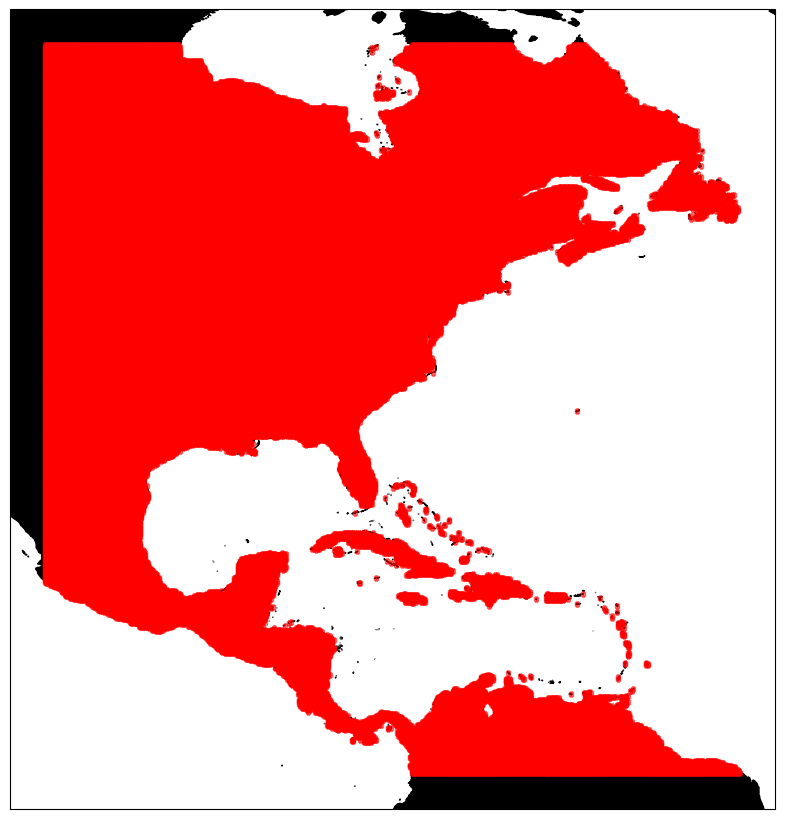

In [4]:
#Here we will create the land sea mask of interest

from IPython import embed
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point
import cartopy
from shapely.prepared import prep
import seaborn as sns


land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m')
land_polygons = list(land_10m.geometries())

lats = np.arange(5, 60, 0.1)
lons = np.arange(-105, -50, 0.1)
lon_grid, lat_grid = np.meshgrid(lons, lats)

points = [Point(point) for point in zip(lon_grid.ravel(), lat_grid.ravel())]


land_polygons_prep = [prep(land_polygon) for land_polygon in land_polygons]


land = []
for land_polygon in land_polygons_prep:
    land.extend([tuple(point.coords)[0] for point in filter(land_polygon.covers, points)])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor=sns.xkcd_rgb['black'])

xs, ys = zip(*land)
ax.scatter(xs, ys, transform=ccrs.PlateCarree(),s=12, marker='s', c='red', alpha=0.5, zorder=2)

In [5]:
# Round each element in xs and ys to the nearest decimal
rounded_xs = [round(x, 1) for x in xs]  # Round to one decimal place
rounded_ys = [round(y, 1) for y in ys]  # Round to one decimal place

In [6]:
#so, now that we have the rounded values of xs and ys, we now need to compare the values of the center of storms
#of interest to this list

#next, we parse through the Hurdat dataset to get the years of interest, to start off we will look
#at just one year to make sure it is doing what I think it is 

#This is the list of unique storms I want to consider\n
CODE = []

#Only interested in the years 1980-2023
with open('/Users/cjmasiel/desktop/HURDAT2.txt', 'r') as ds:
    lines_to_read = 0
    for line in ds:
        values = line.split(",")
        if lines_to_read == 0:
            lines_to_read = int(values[2])
            year = float(values[0][4:8])
            for i in range(1851,2023):
                if year == i:
                    code = values[0]
                    CODE.append(code)
        else:
            lines_to_read -=1 

In [7]:
#Now that we have the storms we are interested in looking, we will loop through the same list as before\n",
#However, this time we will have a bunch of logical \n",

VMAX      = []
LAT       = []
LON       = []
CODE_calc = []
PRES      = []
TIME      = []

with open('/Users/cjmasiel/desktop/HURDAT2.txt', 'r') as ds:
    lines_to_read = 0
    for line in ds:
        values = line.split(",")
        if lines_to_read == 0:
            lines_to_read = int(values[2])
            value_lines_to_read = int(values[2]) 
            code = str(values[0])
        else:
            latitude  = float(values[4][:-1])
            longitude = -1 * float(values[5][:-1])
            vmax      = float(values[6])
            nature    = str(values[3])
            time      = str(values[1])
            pressure  = str(values[7])
            for i in CODE:
                if code == i:        #Just looking to see if the AL number is equal to the one in our list\n",
                    if time not in (' 0000', ' 0600', ' 1200', ' 1800'):
                        #print("Do not Consider, " "Storm =", code, "time =", time)
                        continue
                    elif nature in (' TD', ' TS', ' HU'):
                        VMAX.append(vmax)
                        LAT.append(latitude)
                        LON.append(longitude)
                        CODE_calc.append(code)   
                        PRES.append(pressure)
                        TIME.append(time)
            #now we continue parsing through our data set
            lines_to_read -=1 


print("Length of number of Storms appended = ", len(CODE_calc))
print("Length of intensity list = ", len(VMAX))
print("Length of time list = ", len(TIME))

Length of number of Storms appended =  44008
Length of intensity list =  44008
Length of time list =  44008


In [8]:
# Convert rounded_xs and rounded_ys to set for faster lookup
lookup_set = set(zip(rounded_xs, rounded_ys))

# Using zipped values and their indices to check conditions and build lists
indices = [i for i, (lat, lon) in enumerate(zip(LAT, LON)) if (lon, lat) in lookup_set]

LAND_LAT = [LAT[i] for i in indices]
LAND_LON = [LON[i] for i in indices]
LAND_VMAX = [VMAX[i] for i in indices]
LAND_CODE = [CODE_calc[i] for i in indices]
LAND_PRES = [PRES[i] for i in indices]
LAND_TIME = [TIME[i] for i in indices]

print("length of LAND_LAT =", len(LAND_LAT))
print("length of LAND_PRES =", len(LAND_PRES))
print("length of LAND_TIME =", len(LAND_TIME))

length of LAND_LAT = 4515
length of LAND_PRES = 4515
length of LAND_TIME = 4515


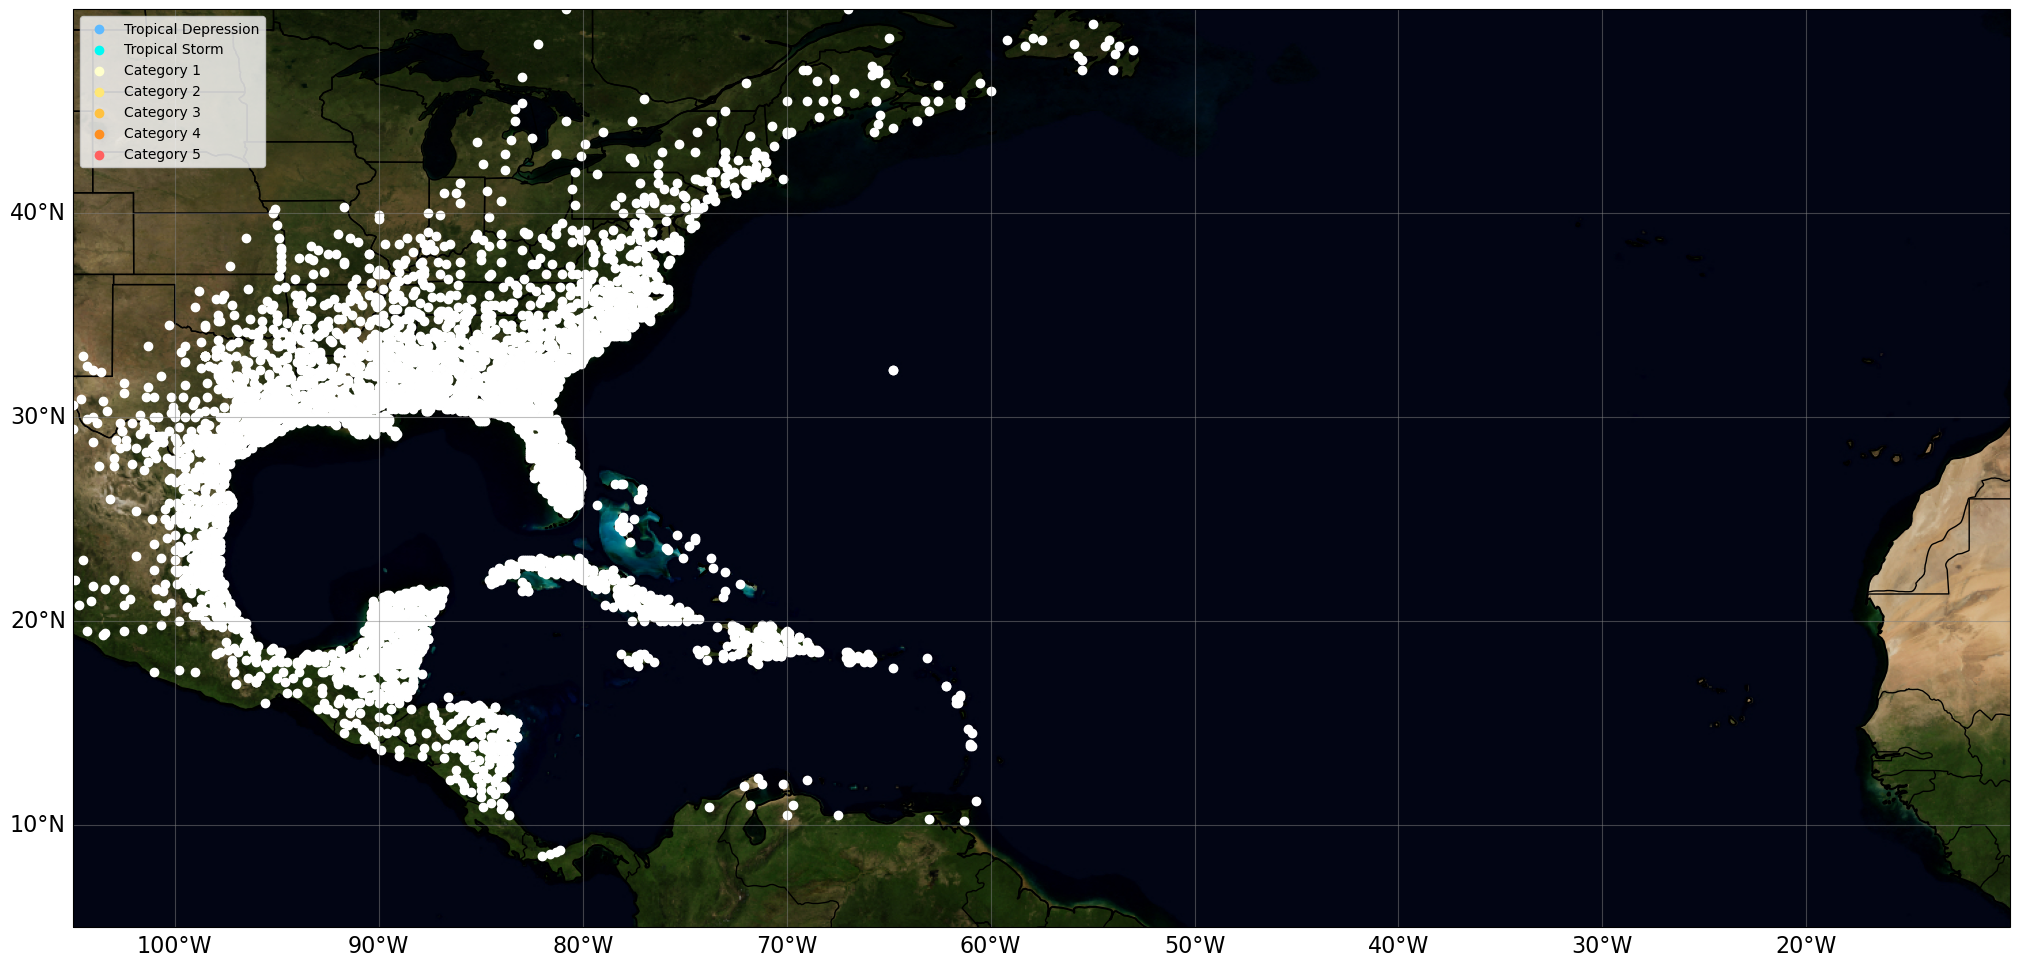

In [11]:
fig, ax = create_map_background()

plt.scatter(LAND_LON, LAND_LAT, color = 'white',zorder=2)

In [12]:
unique_code = set(LAND_CODE)

In [13]:
def plotstorm(a,b,c,d,e,f,g,x):
    Lat = []
    Long = []
    LatStorm = []
    LongStorm = []
    LatStorm1 = []
    LongStorm1 = []
    Lat1 = []
    Long1 = []
    Lat2 = []
    Long2 = []
    Lat3 = []
    Long3 = []
    Lat4 = []
    Long4 = []
    Lat5 = []
    Long5 = []
    LatSS = []
    LongSS = []
    LatEX = []
    LongEX = []
    
    Latorigin = []
    Longorigin = []
    
    first_match = True
    for i in range(len(e)):
        lon_strm   = e[i]
        lat_strm   = f[i]
        code_strm  = g[i]
        if code_strm == x:
            LatStorm1.append(lat_strm)
            LongStorm1.append(lon_strm)
            if first_match:
                Latorigin.append(lat_strm)
                Longorigin.append(lon_strm)
                first_match = False
   
    for i in range(len(a)):
        code      = a[i]
        latitude  = b[i]
        longitude = c[i]
        vmax      = d[i]
        if code == x:
            if vmax < 34:
                Lat.append(latitude)
                Long.append(longitude)
            if 34 <= vmax < 63:
                LatStorm.append(latitude)
                LongStorm.append(longitude)
            if 63 < vmax <= 83:
                Lat1.append(latitude)
                Long1.append(longitude)
            if 83 < vmax <= 95:
                Lat2.append(latitude)
                Long2.append(longitude)
            if 95 < vmax <= 112:
                Lat3.append(latitude)
                Long3.append(longitude)
            if 112 < vmax <= 136:
                Lat4.append(latitude)
                Long4.append(longitude)
            if vmax > 136:
                Lat5.append(latitude)
                Long5.append(longitude)


    #Below is the plotting code \n",
    plt.plot(LongStorm1, LatStorm1, alpha = 1.0, color='grey', linewidth=1,zorder=1)
    plt.scatter(Long, Lat, color = '#5ebaff', label = 'Tropical Depression',zorder=2)
    plt.scatter(LongStorm,LatStorm, color='#00faf4', label = 'Tropical Storm',zorder=3)
    plt.scatter(Long1,Lat1,alpha = 1.0, color='#ffffcc', label = 'Category 1',zorder=4)
    plt.scatter(Long2,Lat2,alpha = 1.0, color='#ffe775', label = 'Category 2',zorder=5)
    plt.scatter(Long3,Lat3,alpha = 1.0, color='#ffc140', label = 'Category 3',zorder=6)
    plt.scatter(Long4,Lat4,alpha = 1.0, color='#ff8f20', label = 'Category 4',zorder=7)
    plt.scatter(Long5,Lat5,alpha = 1.0, color='#ff6060', label = 'Category 5',zorder=8)
    plt.scatter(LongEX,LatEX,alpha = 1.0, color='#5ebaff', marker  = 'v', label = 'Extra-Tropical',zorder=9)
    plt.scatter(LongSS,LatSS,alpha = 1.0, color='#00faf4', marker = 'v', label = 'Sub-Tropical Storm',zorder=10)
    
    plt.scatter(Longorigin,Latorigin, alpha = 1.0, color='white', marker = 'v',zorder=10)

    plt.title('1851-2022 North Atlantic Landfalling Tropical Cyclones',{"fontsize": 20}, loc = 'left')
    plt.title('Product by: Cameron Masiello',{"fontsize": 20}, loc = 'right')

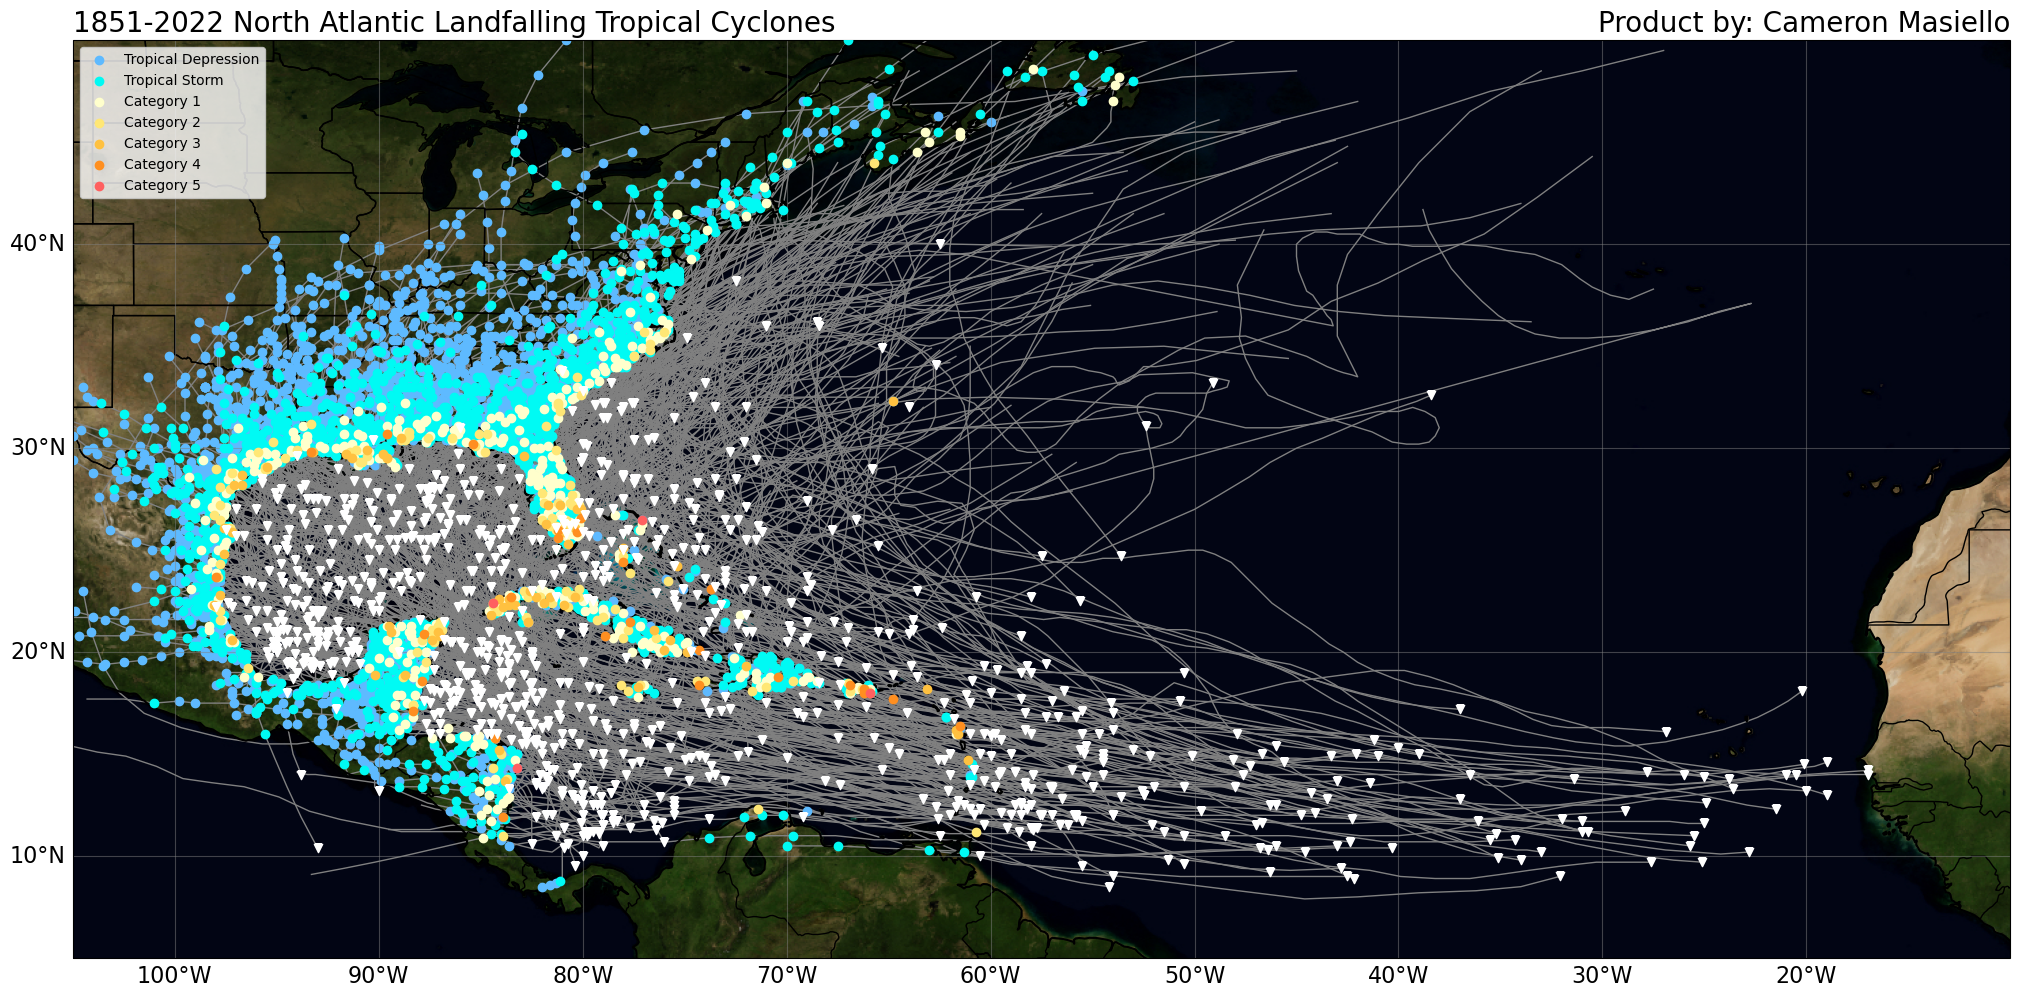

In [14]:
fig, ax = create_map_background()

for item in unique_code:
    plotstorm(LAND_CODE, LAND_LAT, LAND_LON, LAND_VMAX, LON, LAT, CODE_calc, item)

In [15]:
def plotstorm(a,b,c,d,e,f,g,x):
    Lat = []
    Long = []
    LatStorm = []
    LongStorm = []
    LatStorm1 = []
    LongStorm1 = []
    Lat1 = []
    Long1 = []
    Lat2 = []
    Long2 = []
    Lat3 = []
    Long3 = []
    Lat4 = []
    Long4 = []
    Lat5 = []
    Long5 = []
    LatSS = []
    LongSS = []
    LatEX = []
    LongEX = []
    
    Latorigin = []
    Longorigin = []
    
    Lat_land_origin = []
    Long_land_origin = []
    
    
    first_match = True
    for i in range(len(e)):
        lon_strm   = e[i]
        lat_strm   = f[i]
        code_strm  = g[i]
        if code_strm == x:
            LatStorm1.append(lat_strm)
            LongStorm1.append(lon_strm)

    first_match = True
    for i in range(len(a)):
        code      = a[i]
        latitude  = b[i]
        longitude = c[i]
        vmax      = d[i]
        if code == x:
            if first_match:
                Lat_land_origin.append(latitude)
                Long_land_origin.append(longitude)
                first_match = False
            if vmax < 34:
                Lat.append(latitude)
                Long.append(longitude)
            if 34 <= vmax < 63:
                LatStorm.append(latitude)
                LongStorm.append(longitude)
            if 63 < vmax <= 83:
                Lat1.append(latitude)
                Long1.append(longitude)
            if 83 < vmax <= 95:
                Lat2.append(latitude)
                Long2.append(longitude)
            if 95 < vmax <= 112:
                Lat3.append(latitude)
                Long3.append(longitude)
            if 112 < vmax <= 136:
                Lat4.append(latitude)
                Long4.append(longitude)
            if vmax > 136:
                Lat5.append(latitude)
                Long5.append(longitude)


    #Below is the plotting code \n",
    plt.plot(LongStorm1, LatStorm1, alpha = 1.0, color='grey', linewidth=1,zorder=1)
    plt.scatter(Long, Lat, color = '#5ebaff', label = 'Tropical Depression',zorder=2)
    plt.scatter(LongStorm,LatStorm, color='#00faf4', label = 'Tropical Storm',zorder=3)
    plt.scatter(Long1,Lat1,alpha = 1.0, color='#ffffcc', label = 'Category 1',zorder=4)
    plt.scatter(Long2,Lat2,alpha = 1.0, color='#ffe775', label = 'Category 2',zorder=5)
    plt.scatter(Long3,Lat3,alpha = 1.0, color='#ffc140', label = 'Category 3',zorder=6)
    plt.scatter(Long4,Lat4,alpha = 1.0, color='#ff8f20', label = 'Category 4',zorder=7)
    plt.scatter(Long5,Lat5,alpha = 1.0, color='#ff6060', label = 'Category 5',zorder=8)
    plt.scatter(LongEX,LatEX,alpha = 1.0, color='#5ebaff', marker  = 'v', label = 'Extra-Tropical',zorder=9)
    plt.scatter(LongSS,LatSS,alpha = 1.0, color='#00faf4', marker = 'v', label = 'Sub-Tropical Storm',zorder=10)
    
    plt.scatter(Long_land_origin,Lat_land_origin, alpha = 1.0, color='pink', marker = 'v',zorder=10)

    plt.title('1851-2022 North Atlantic Landfalling Tropical Cyclones',{"fontsize": 20}, loc = 'left')
    plt.title('Product by: Cameron Masiello',{"fontsize": 20}, loc = 'right')

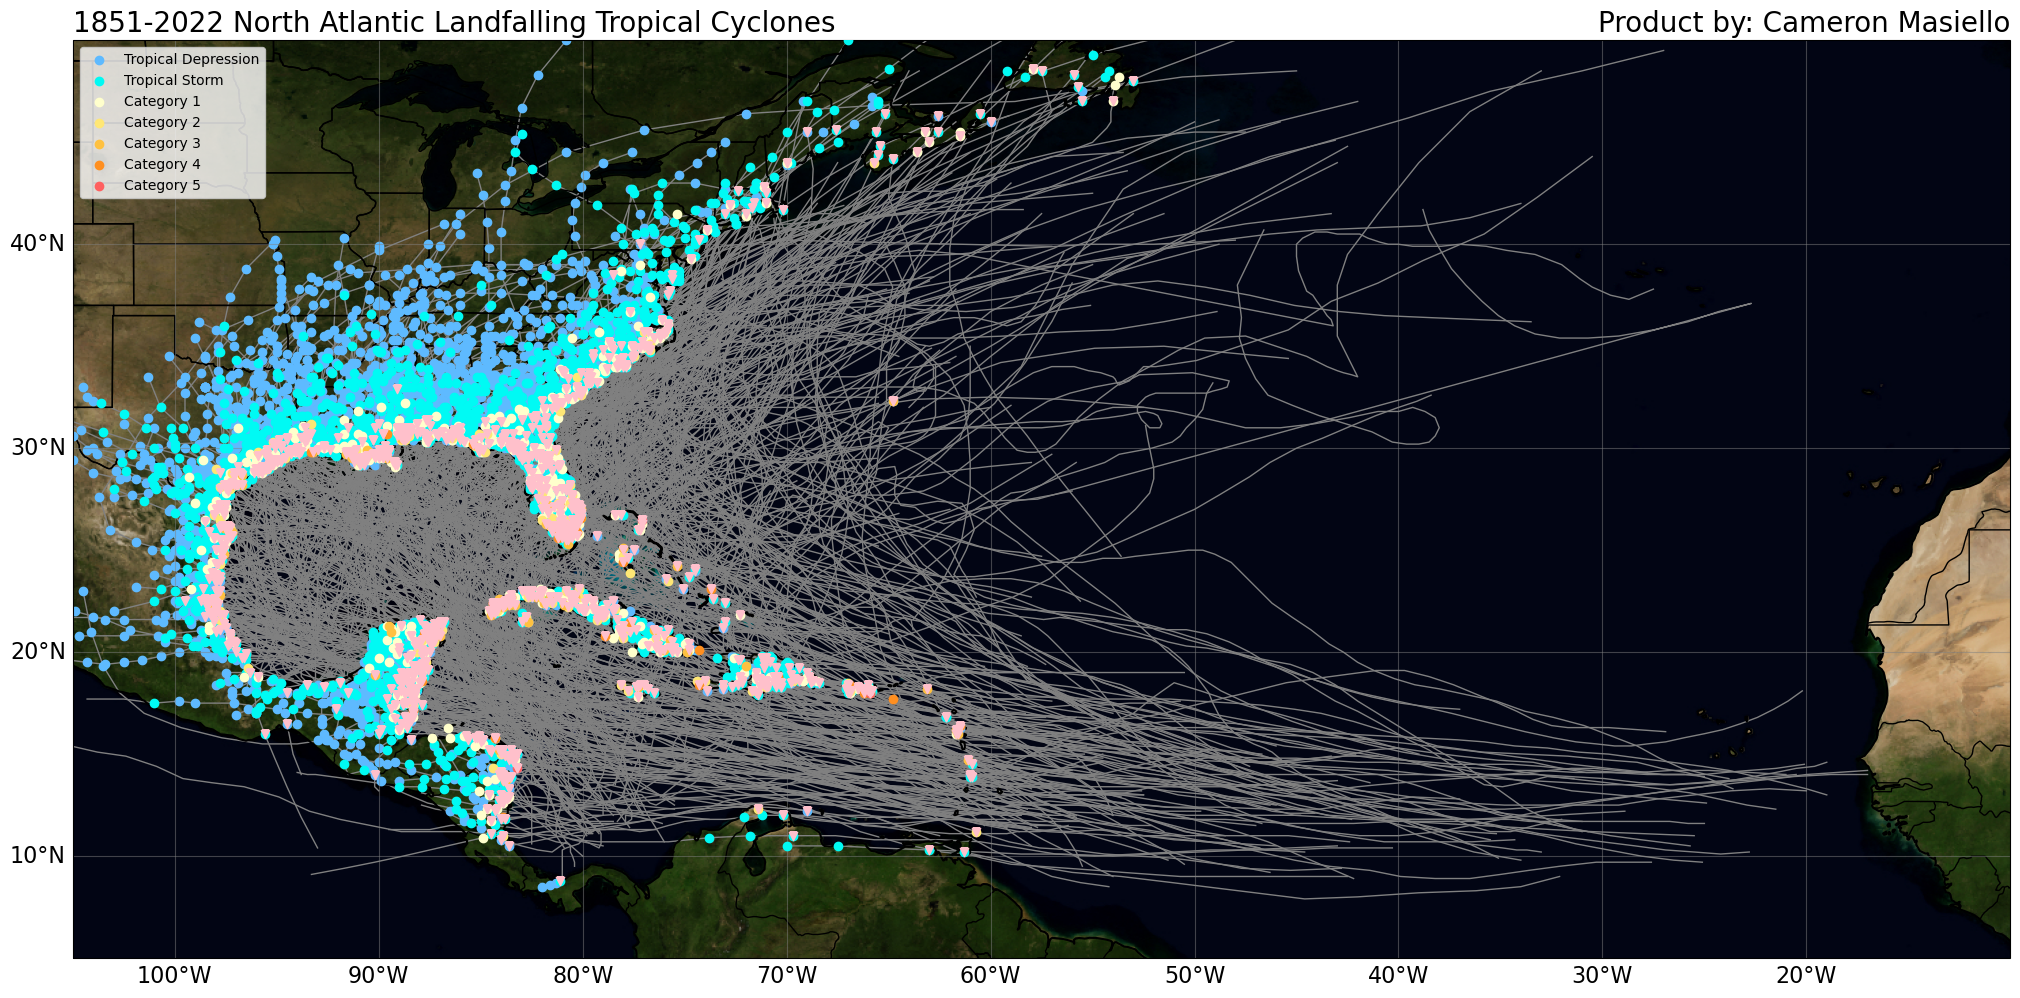

In [16]:
fig, ax = create_map_background()

for item in unique_code:
    plotstorm(LAND_CODE, LAND_LAT, LAND_LON, LAND_VMAX, LON, LAT, CODE_calc, item)

In [17]:
def find_consecutive_sublists(lst1, lst2):
    # A helper function to check if a sublist exists in another list
    def is_sublist(sub, lst):
        for i in range(len(lst) - len(sub) + 1):
            if lst[i:i+len(sub)] == sub:
                return True
        return False

    consecutive_sets = []
    skipped_indices = __builtins__.set()

    for i in range(len(lst1)):
        if i in skipped_indices:
            continue
        for j in range(len(lst1), i, -1):
            sublist = lst1[i:j]
            if is_sublist(sublist, lst2) and sublist not in consecutive_sets:
                consecutive_sets.append(sublist)
                skipped_indices.update(range(i, j))
                break

    return consecutive_sets

In [18]:
#Daytime landfall: AKA 18z and 0z

def Wind_Decay_new_day(a,b,c,d,e,f,g,x,t):
    velocity = []
    time = []
    LatStorm = []
    LongStorm = []
    LatLand = []
    LonLand = []
    
    #this loop looks through the whole lat/long list of the storm
    first_match = True
    for i in range(len(e)):
        lon_strm   = e[i]
        lat_strm   = f[i]
        code_strm  = g[i]
        if code_strm == x:
            LatStorm.append(lat_strm)
            LongStorm.append(lon_strm)

    
    for i in range(len(a)):
        code      = a[i]
        latitude  = b[i]
        longitude = c[i]
        vmax      = d[i]
        if code == x and vmax > 0:
            #velocity.append(vmax)
            LonLand.append(longitude)
            LatLand.append(latitude)

    def find_consecutive_sublists(lst1_lat, lst1_lon, lst2_lat, lst2_lon):
    
        # Zipping latitude and longitude lists to work with pairs
        lst1 = list(zip(lst1_lat, lst1_lon))
        lst2 = list(zip(lst2_lat, lst2_lon))

        # A helper function to check if a sublist exists in another list
        def is_sublist(sub, lst):
            for i in range(len(lst) - len(sub) + 1):
                if lst[i:i+len(sub)] == sub:
                    return True
            return False

        consecutive_sets = []
        skipped_indices = __builtins__.set()

        for i in range(len(lst1)):
            if i in skipped_indices:
                continue
            for j in range(len(lst1), i, -1):
                sublist = lst1[i:j]
                if is_sublist(sublist, lst2) and sublist not in consecutive_sets:
                    consecutive_sets.append(sublist)
                    skipped_indices.update(range(i, j))
                    break

        # Unzipping the results to return separate latitude and longitude lists
        lat_results, lon_results = [], []
        for sublist in consecutive_sets:
            sub_lat, sub_lon = zip(*sublist)
            lat_results.append(list(sub_lat))
            lon_results.append(list(sub_lon))

        return lat_results, lon_results
    
    lat_results, lon_results = find_consecutive_sublists(LatLand, LonLand, LatStorm, LongStorm)
    
    #print("lat set = ",lat_results,"lon set = ", lon_results)

    
    #create list of velocities:
    velocity = []

    # Assuming lat_results and lon_results have been obtained from the previous function call.
    for lat_sublist, lon_sublist in zip(lat_results, lon_results):
        current_velocity = []

        first_match = True
        # Zipping the latitudes and longitudes so we can iterate over the pairs
        for lat_value, lon_value in zip(lat_sublist, lon_sublist):
            for k in range(len(a)):
                latitude = b[k]
                longitude = c[k]
                vmax = d[k]
                code = a[k]
                time = t[k]

                if code == x and lat_value == latitude and lon_value == longitude and vmax > 0:
                    if first_match:
                        time_landfall = time
                        first_match = False
                    #if time_landfall in (' 0000', ' 1800'):
                    if time_landfall in (' 0000', ' 1800'):
                        current_velocity.append(vmax)
                        break  # exit the inner loop once a match is found

        velocity.append(current_velocity)
        
    time = []

    for sublist in velocity:
        # Create a new sublist for this part of the velocity
        current_time = [(j * 6) for j in range(len(sublist))]

        # Append the current sublist to the main time list
        time.append(current_time)

    #Below is the plotting code \n",
    for i in range(len(velocity)):
        #print("Velocity list =", velocity[i], "Time list =", time[i])
        plt.plot(time[i], velocity[i], "-o", color = 'black')

        plt.title('1851-2022 North Atlantic Landfalling Tropical Cyclones (Day)',{"fontsize": 12}, loc = 'left')
        plt.title('Product by: Cameron Masiello',{"fontsize": 10}, loc = 'right')

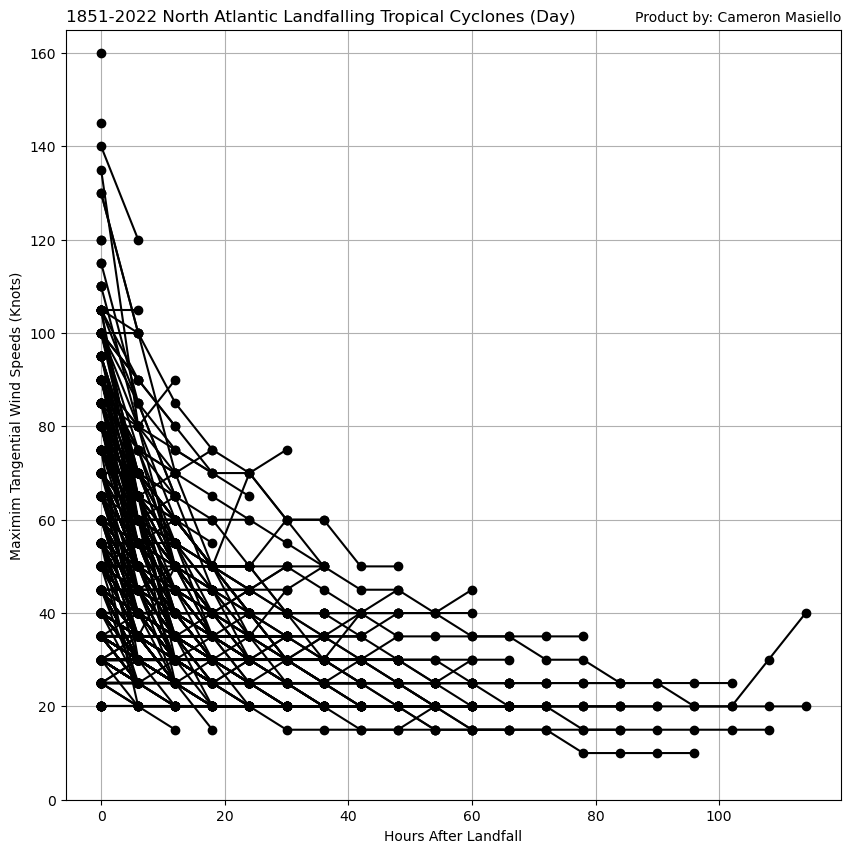

In [19]:
fig = plt.figure(figsize=(10, 10))
plt.grid()
plt.ylim(0, 165)
plt.ylabel('Maximim Tangential Wind Speeds (Knots)')
plt.xlabel('Hours After Landfall')

for item in unique_code:
    Wind_Decay_new_day(LAND_CODE, LAND_LAT, LAND_LON, LAND_VMAX, LON, LAT, CODE_calc, item, LAND_TIME)

In [20]:
#Daytime landfall: AKA 6z and 12z

def Wind_Decay_new_night(a,b,c,d,e,f,g,x,t):
    velocity = []
    time = []
    LatStorm = []
    LongStorm = []
    LatLand = []
    LonLand = []
    
    #this loop looks through the whole lat/long list of the storm
    first_match = True
    for i in range(len(e)):
        lon_strm   = e[i]
        lat_strm   = f[i]
        code_strm  = g[i]
        if code_strm == x:
            LatStorm.append(lat_strm)
            LongStorm.append(lon_strm)

    
    for i in range(len(a)):
        code      = a[i]
        latitude  = b[i]
        longitude = c[i]
        vmax      = d[i]
        if code == x and vmax > 0:
            #velocity.append(vmax)
            LonLand.append(longitude)
            LatLand.append(latitude)

    def find_consecutive_sublists(lst1_lat, lst1_lon, lst2_lat, lst2_lon):
    
        # Zipping latitude and longitude lists to work with pairs
        lst1 = list(zip(lst1_lat, lst1_lon))
        lst2 = list(zip(lst2_lat, lst2_lon))

        # A helper function to check if a sublist exists in another list
        def is_sublist(sub, lst):
            for i in range(len(lst) - len(sub) + 1):
                if lst[i:i+len(sub)] == sub:
                    return True
            return False

        consecutive_sets = []
        skipped_indices = __builtins__.set()

        for i in range(len(lst1)):
            if i in skipped_indices:
                continue
            for j in range(len(lst1), i, -1):
                sublist = lst1[i:j]
                if is_sublist(sublist, lst2) and sublist not in consecutive_sets:
                    consecutive_sets.append(sublist)
                    skipped_indices.update(range(i, j))
                    break

        # Unzipping the results to return separate latitude and longitude lists
        lat_results, lon_results = [], []
        for sublist in consecutive_sets:
            sub_lat, sub_lon = zip(*sublist)
            lat_results.append(list(sub_lat))
            lon_results.append(list(sub_lon))

        return lat_results, lon_results
    
    lat_results, lon_results = find_consecutive_sublists(LatLand, LonLand, LatStorm, LongStorm)
    
    #print("lat set = ",lat_results,"lon set = ", lon_results)

    
    #create list of velocities:
    velocity = []

    # Assuming lat_results and lon_results have been obtained from the previous function call.
    for lat_sublist, lon_sublist in zip(lat_results, lon_results):
        current_velocity = []

        first_match = True
        # Zipping the latitudes and longitudes so we can iterate over the pairs
        for lat_value, lon_value in zip(lat_sublist, lon_sublist):
            for k in range(len(a)):
                latitude = b[k]
                longitude = c[k]
                vmax = d[k]
                code = a[k]
                time = t[k]

                if code == x and lat_value == latitude and lon_value == longitude and vmax > 0:
                    if first_match:
                        time_landfall = time
                        first_match = False
                    if time_landfall in (' 0600', ' 1200'):
                        current_velocity.append(vmax)
                        break  # exit the inner loop once a match is found

        velocity.append(current_velocity)
        
    time = []

    for sublist in velocity:
        # Create a new sublist for this part of the velocity
        current_time = [(j * 6) for j in range(len(sublist))]

        # Append the current sublist to the main time list
        time.append(current_time)

    #Below is the plotting code \n",
    for i in range(len(velocity)):
        #print("Velocity list =", velocity[i], "Time list =", time[i])
        plt.plot(time[i], velocity[i], "-o", color = 'black')

        plt.title('1851-2022 North Atlantic Landfalling Tropical Cyclones (Night)',{"fontsize": 12}, loc = 'left')
        plt.title('Product by: Cameron Masiello',{"fontsize": 10}, loc = 'right')

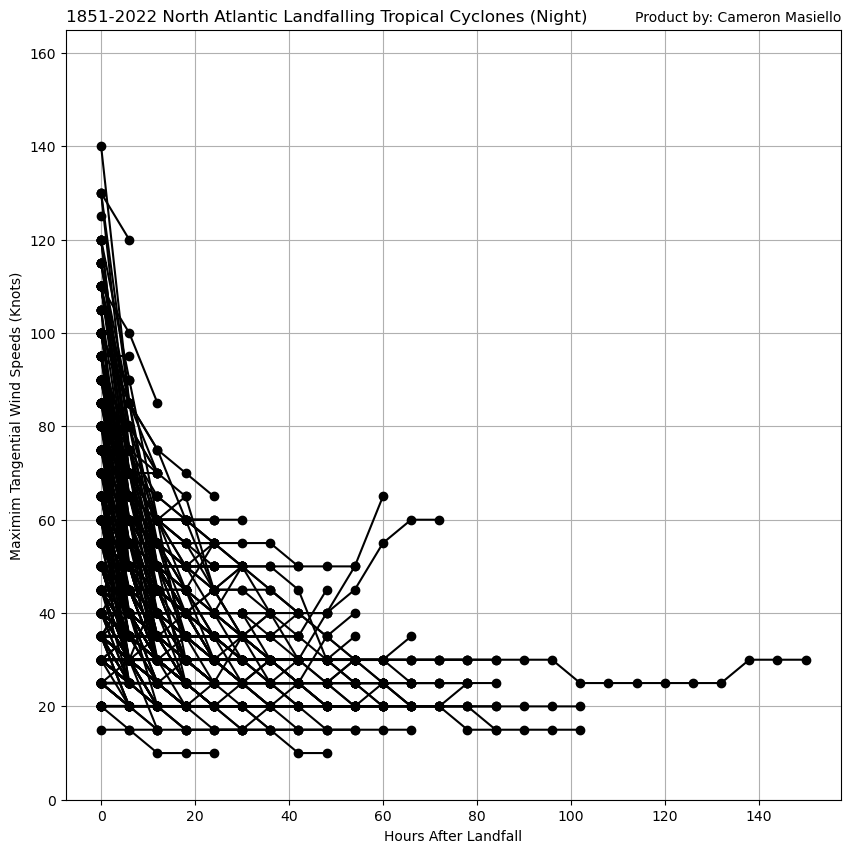

In [21]:
fig = plt.figure(figsize=(10, 10))
plt.grid()
plt.ylim(0, 165)
plt.ylabel('Maximim Tangential Wind Speeds (Knots)')
plt.xlabel('Hours After Landfall')

for item in unique_code:
    Wind_Decay_new_night(LAND_CODE, LAND_LAT, LAND_LON, LAND_VMAX, LON, LAT, CODE_calc, item, LAND_TIME)

In [22]:
all_tau_n_day = []
all_v_n_day = []
year_n_day = []

In [23]:
#now, lets calcualte 6,12,18,and 24 hour tau as a funciton of Landfall Intensity, the value of tau will
#be on the x-axis, Maximum Tangential winds will be on the x-axis

def Wind_Decay_new_tau_day(a,b,c,d,e,f,g,x,t):
    velocity = []
    time = []
    LatStorm = []
    LongStorm = []
    LatLand = []
    LonLand = []
    
    #this loop looks through the whole lat/long list of the storm
    first_match = True
    for i in range(len(e)):
        lon_strm   = e[i]
        lat_strm   = f[i]
        code_strm  = g[i]
        if code_strm == x:
            LatStorm.append(lat_strm)
            LongStorm.append(lon_strm)

    
    for i in range(len(a)):
        code      = a[i]
        latitude  = b[i]
        longitude = c[i]
        vmax      = d[i]
        if code == x and vmax > 0:
            #velocity.append(vmax)
            LonLand.append(longitude)
            LatLand.append(latitude)

    def find_consecutive_sublists(lst1_lat, lst1_lon, lst2_lat, lst2_lon):
    
        # Zipping latitude and longitude lists to work with pairs
        lst1 = list(zip(lst1_lat, lst1_lon))
        lst2 = list(zip(lst2_lat, lst2_lon))

        # A helper function to check if a sublist exists in another list
        def is_sublist(sub, lst):
            for i in range(len(lst) - len(sub) + 1):
                if lst[i:i+len(sub)] == sub:
                    return True
            return False

        consecutive_sets = []
        skipped_indices = __builtins__.set()

        for i in range(len(lst1)):
            if i in skipped_indices:
                continue
            for j in range(len(lst1), i, -1):
                sublist = lst1[i:j]
                if is_sublist(sublist, lst2) and sublist not in consecutive_sets:
                    consecutive_sets.append(sublist)
                    skipped_indices.update(range(i, j))
                    break

        # Unzipping the results to return separate latitude and longitude lists
        lat_results, lon_results = [], []
        for sublist in consecutive_sets:
            sub_lat, sub_lon = zip(*sublist)
            lat_results.append(list(sub_lat))
            lon_results.append(list(sub_lon))

        return lat_results, lon_results
    
    lat_results, lon_results = find_consecutive_sublists(LatLand, LonLand, LatStorm, LongStorm)
    
    #print("lat set = ",lat_results,"lon set = ", lon_results)

    
    #create list of velocities:
    velocity = []

    # Assuming lat_results and lon_results have been obtained from the previous function call.
    for lat_sublist, lon_sublist in zip(lat_results, lon_results):
        current_velocity = []

        #set the first_match flag to true before we iterate through the loop
        first_match = True
        
        # Zipping the latitudes and longitudes so we can iterate over the pairs
        for lat_value, lon_value in zip(lat_sublist, lon_sublist):
            for k in range(len(a)):
                latitude = b[k]
                longitude = c[k]
                vmax = d[k]
                code = a[k]
                time = t[k]

                if code == x and lat_value == latitude and lon_value == longitude and vmax > 0:
                    if first_match:
                        time_landfall = time
                        first_match = False
                    if time_landfall in (' 0000', ' 1800'):
                        current_velocity.append(vmax)
                        break  # exit the inner loop once a match is found

        velocity.append(current_velocity)
        
    time_plot = []
    
    for i in range(len(velocity)):     
        #First create the lists we are going to append to to conduct our calculations
        y_list = []
        x_list = []
        
        v = velocity[i]
        if len(v) >= 5:
            for j in range(0,5):
                t = j * 6
                y_value = np.log(v[j]/v[0])
                y_list.append(y_value)
                x_list.append(t)
        
        if len(v) >= 5:
        #calculate the linear regression
            slope, intercept, r_value, p_value, std_err = linregress(x_list, y_list)

            plt.plot(x_list, y_list, "o", color = 'black')
        
            tau_n = -(1/slope)
            all_tau_n_day.append(tau_n)
            all_v_n_day.append(v[0])
            year_n_day.append(x[4:8])

            #plot the linear regression
            regression_line = [slope*xi + intercept for xi in x_list]
            plt.plot(x_list,regression_line, color = 'red', label = 'linear_regresssion')

            plt.title('1851-2022 North Atlantic Landfalling Tropical Cyclones (Day)',{"fontsize": 12}, loc = 'left')
            plt.title('Product by: Cameron Masiello',{"fontsize": 10}, loc = 'right')   

/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_4673/3424424252.py:123: RuntimeWarning: divide by zero encountered in double_scalars
  tau_n = -(1/slope)


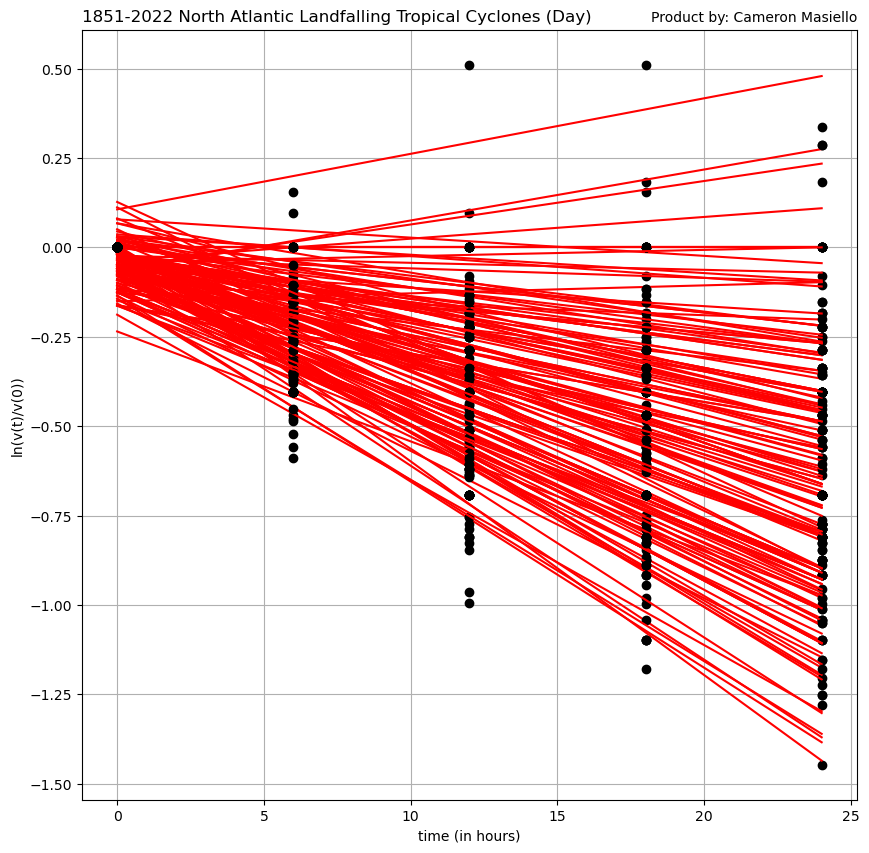

In [24]:
fig = plt.figure(figsize=(10, 10))
plt.grid()
plt.xlabel('time (in hours)')
plt.ylabel('ln(v(t)/v(0))')
#plt.ylim(0,70)

for item in unique_code:
    Wind_Decay_new_tau_day(LAND_CODE, LAND_LAT, LAND_LON, LAND_VMAX, LON, LAT, CODE_calc, item, LAND_TIME)

In [25]:
all_v_pos_day = []
all_t_pos_day = []
all_year_pos_day = []
for i in range(len(all_tau_n_day)):
    if all_tau_n_day[i] >=0:
        all_v_pos_day.append(all_v_n_day[i])
        all_t_pos_day.append(all_tau_n_day[i])
        all_year_pos_day.append(year_n_day[i])

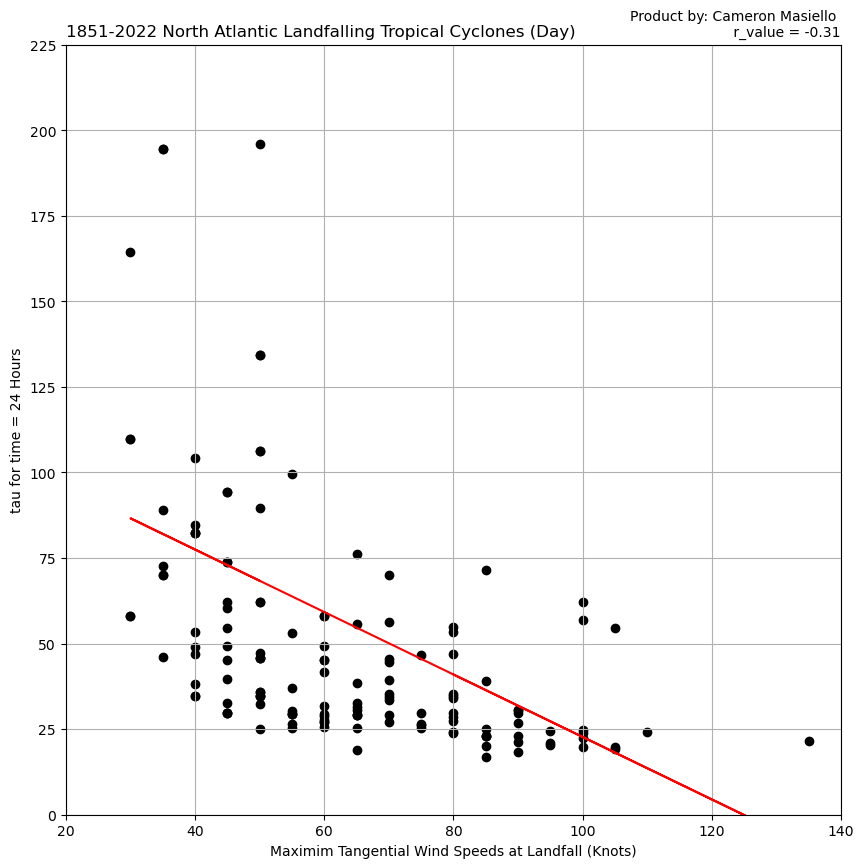

In [26]:
#calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(all_v_pos_day, all_t_pos_day)

fig = plt.figure(figsize=(10, 10))
plt.grid()
plt.ylim(0, 225)
plt.xlim(20, 140)
plt.xlabel('Maximim Tangential Wind Speeds at Landfall (Knots)')
plt.ylabel('tau for time = 24 Hours')
plt.title('1851-2022 North Atlantic Landfalling Tropical Cyclones (Day)',{"fontsize": 12}, loc = 'left')
plt.title(f'Product by: Cameron Masiello \n r_value = {r_value: .2f}', {"fontsize": 10}, loc = 'right')

#scatter plot
plt.scatter(all_v_pos_day, all_t_pos_day, color = 'black')
#plot the linear regression
regression_line = [slope*xi + intercept for xi in all_v_pos_day]
plt.plot(all_v_pos_day, regression_line, color = 'red', label = 'linear_regresssion')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


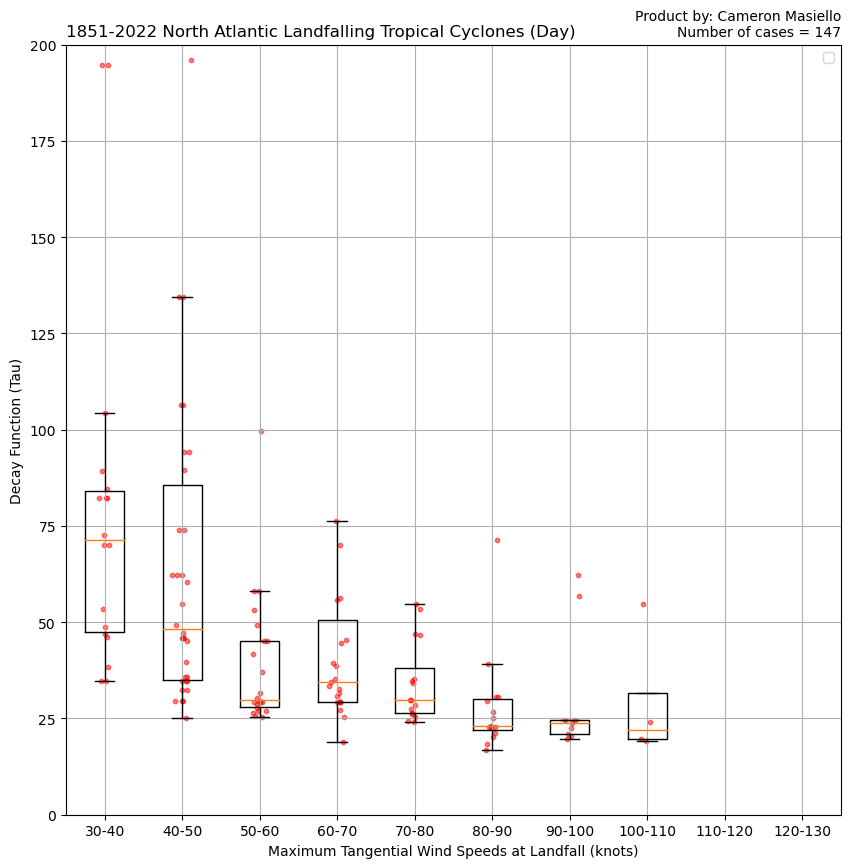

In [27]:
# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(all_v_pos_day, all_t_pos_day)

# Define the bin width
bin_width = 10

# Calculate the number of bins based on the bin width
num_bins = int((max(all_v_pos_day) - min(all_v_pos_day)) / bin_width)

# Create bin ranges with increments of 10
bin_ranges = [min(all_v_pos_day) + i * bin_width for i in range(num_bins)]
bin_ranges.append(bin_ranges[-1] + bin_width)

# Assuming all_v_pos_day and all_t_pos_day are NumPy arrays
all_v_pos_day = np.array(all_v_pos_day)
all_t_pos_day = np.array(all_t_pos_day)

# Initialize an empty list to store the data within each bin
bin_data = []

# Calculate the data within each bin
for i in range(num_bins): 
    mask = (all_v_pos_day > bin_ranges[i]) & (all_v_pos_day <= bin_ranges[i+1])
    bin_values = [all_t_pos_day[j] for j in range(len(mask)) if mask[j]]
    bin_data.append(bin_values)

# Create a box and whisker plot
fig = plt.figure(figsize=(10, 10))

# Plot the box and whisker plots
boxplot = plt.boxplot(bin_data, labels=[f'{bin_ranges[i]:.0f}-{bin_ranges[i+1]:.0f}' for i in range(num_bins)], showfliers=False)

# Overlay individual data points
for i, data in enumerate(bin_data, start=1):
    # Add a random jitter in the x-direction
    jitter = 0.05 * np.random.randn(len(data))
    plt.scatter(jitter + i, data, alpha=0.5, marker='o', color='red', s=10)

plt.grid() 
plt.legend()
plt.ylim(0,200)

plt.xlabel('Maximum Tangential Wind Speeds at Landfall (knots)')
plt.ylabel('Decay Function (Tau)')
plt.title('1851-2022 North Atlantic Landfalling Tropical Cyclones (Day)', fontsize=12, loc='left')
plt.title(f'Product by: Cameron Masiello\nNumber of cases = {len(all_v_pos_day)}', fontsize=10, loc='right')

plt.show()

In [28]:
all_tau_n_night = []
all_v_n_night = []
year_n_night = []

In [29]:
#now, lets calcualte 6,12,18,and 24 hour tau as a funciton of Landfall Intensity, the value of tau will
#be on the x-axis, Maximum Tangential winds will be on the x-axis

def Wind_Decay_new_tau_night(a,b,c,d,e,f,g,x,t):
    velocity = []
    time = []
    LatStorm = []
    LongStorm = []
    LatLand = []
    LonLand = []
    
    #this loop looks through the whole lat/long list of the storm
    first_match = True
    for i in range(len(e)):
        lon_strm   = e[i]
        lat_strm   = f[i]
        code_strm  = g[i]
        if code_strm == x:
            LatStorm.append(lat_strm)
            LongStorm.append(lon_strm)

    
    for i in range(len(a)):
        code      = a[i]
        latitude  = b[i]
        longitude = c[i]
        vmax      = d[i]
        if code == x and vmax > 0:
            #velocity.append(vmax)
            LonLand.append(longitude)
            LatLand.append(latitude)

    def find_consecutive_sublists(lst1_lat, lst1_lon, lst2_lat, lst2_lon):
    
        # Zipping latitude and longitude lists to work with pairs
        lst1 = list(zip(lst1_lat, lst1_lon))
        lst2 = list(zip(lst2_lat, lst2_lon))

        # A helper function to check if a sublist exists in another list
        def is_sublist(sub, lst):
            for i in range(len(lst) - len(sub) + 1):
                if lst[i:i+len(sub)] == sub:
                    return True
            return False

        consecutive_sets = []
        skipped_indices = __builtins__.set()

        for i in range(len(lst1)):
            if i in skipped_indices:
                continue
            for j in range(len(lst1), i, -1):
                sublist = lst1[i:j]
                if is_sublist(sublist, lst2) and sublist not in consecutive_sets:
                    consecutive_sets.append(sublist)
                    skipped_indices.update(range(i, j))
                    break

        # Unzipping the results to return separate latitude and longitude lists
        lat_results, lon_results = [], []
        for sublist in consecutive_sets:
            sub_lat, sub_lon = zip(*sublist)
            lat_results.append(list(sub_lat))
            lon_results.append(list(sub_lon))

        return lat_results, lon_results
    
    lat_results, lon_results = find_consecutive_sublists(LatLand, LonLand, LatStorm, LongStorm)
    
    #print("lat set = ",lat_results,"lon set = ", lon_results)

    
    #create list of velocities:
    velocity = []

    # Assuming lat_results and lon_results have been obtained from the previous function call.
    for lat_sublist, lon_sublist in zip(lat_results, lon_results):
        current_velocity = []

        first_match = True
        # Zipping the latitudes and longitudes so we can iterate over the pairs
        for lat_value, lon_value in zip(lat_sublist, lon_sublist):
            for k in range(len(a)):
                latitude = b[k]
                longitude = c[k]
                vmax = d[k]
                code = a[k]
                time = t[k]

                if code == x and lat_value == latitude and lon_value == longitude and vmax > 0:
                    if first_match:
                        time_landfall = time
                        first_match = False
                    if time_landfall in (' 0600', ' 1200'):
                        current_velocity.append(vmax)
                        break  # exit the inner loop once a match is found

        velocity.append(current_velocity)
        
    time = []

    for sublist in velocity:
        # Create a new sublist for this part of the velocity
        current_time = [(j * 6) for j in range(len(sublist))]

        # Append the current sublist to the main time list
        time.append(current_time)
    
    #How do we calculate tau? we plot ln(v(t)/v(0)) vs time, and then take the best-linear-fit-line to the
    #data points for the first 24 hours
    
    for i in range(len(velocity)):     
        #First create the lists we are going to append to to conduct our calculations
        y_list = []
        x_list = []
        
        v = velocity[i]
        if len(v) >= 5:
            for j in range(0,5):
                t = j * 6
                y_value = np.log(v[j]/v[0])
                y_list.append(y_value)
                x_list.append(t)
        
        if len(v) >= 5:
        #calculate the linear regression
            slope, intercept, r_value, p_value, std_err = linregress(x_list, y_list)

            plt.plot(x_list, y_list, "o", color = 'black')
        
            tau_n = -(1/slope)
            all_tau_n_night.append(tau_n)
            all_v_n_night.append(v[0])
            year_n_night.append(x[4:8])

            #plot the linear regression
            regression_line = [slope*xi + intercept for xi in x_list]
            plt.plot(x_list,regression_line, color = 'red', label = 'linear_regresssion')

            plt.title('1851-2022 North Atlantic Landfalling Tropical Cyclones (Night)',{"fontsize": 12}, loc = 'left')
            plt.title('Product by: Cameron Masiello',{"fontsize": 10}, loc = 'right')   

/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_4673/824550963.py:131: RuntimeWarning: divide by zero encountered in double_scalars
  tau_n = -(1/slope)


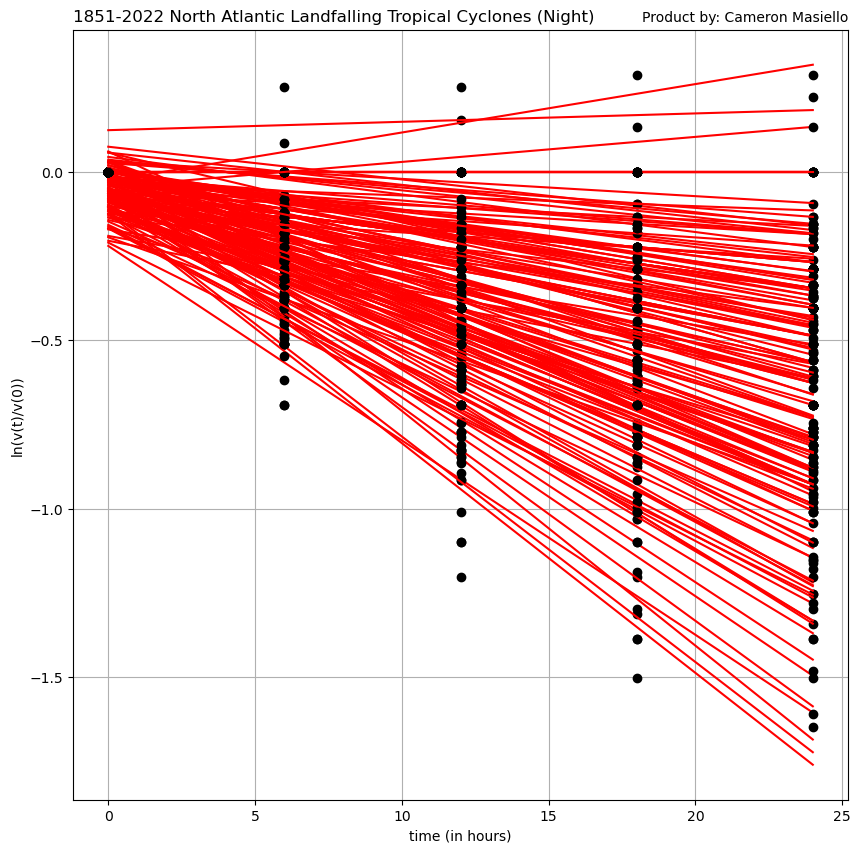

In [30]:
fig = plt.figure(figsize=(10, 10))
plt.grid()
plt.xlabel('time (in hours)')
plt.ylabel('ln(v(t)/v(0))')
#plt.ylim(0,70)

for item in unique_code:
    Wind_Decay_new_tau_night(LAND_CODE, LAND_LAT, LAND_LON, LAND_VMAX, LON, LAT, CODE_calc, item, LAND_TIME)

In [31]:
all_v_pos_night = []
all_t_pos_night = []
all_year_pos_night = []
for i in range(len(all_tau_n_night)):
    if all_tau_n_night[i] >=0:
        all_v_pos_night.append(all_v_n_night[i])
        all_t_pos_night.append(all_tau_n_night[i])
        all_year_pos_night.append(year_n_night[i])

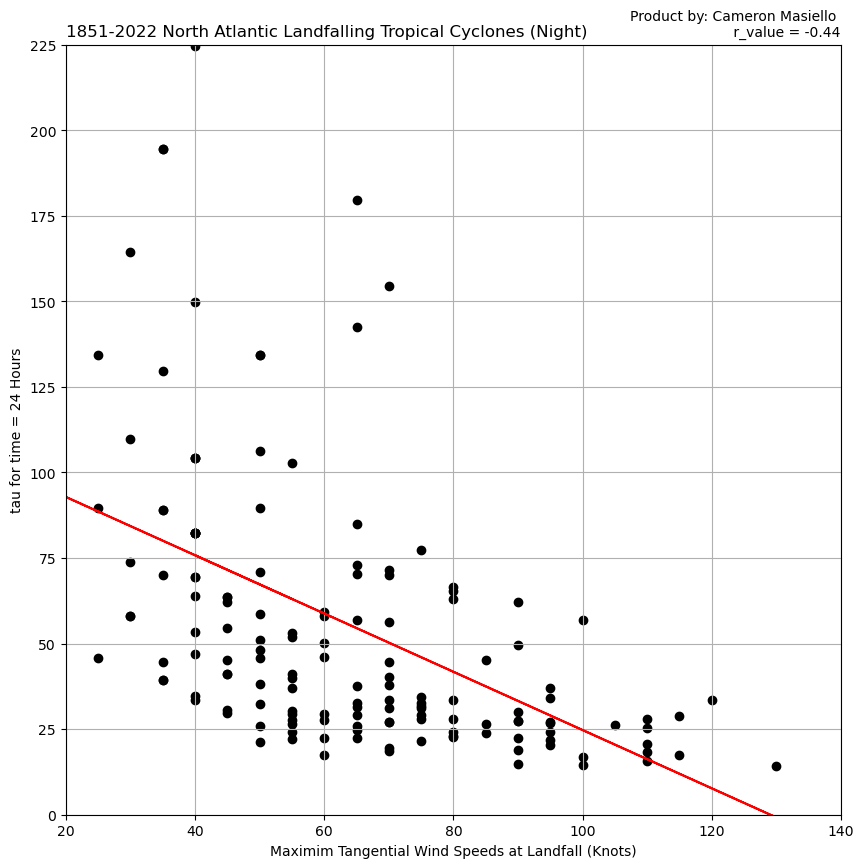

In [32]:
#calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(all_v_pos_night, all_t_pos_night)

fig = plt.figure(figsize=(10, 10))
plt.grid()
plt.ylim(0, 225)
plt.xlim(20, 140)
plt.xlabel('Maximim Tangential Wind Speeds at Landfall (Knots)')
plt.ylabel('tau for time = 24 Hours')
plt.title('1851-2022 North Atlantic Landfalling Tropical Cyclones (Night)',{"fontsize": 12}, loc = 'left')
plt.title(f'Product by: Cameron Masiello \n r_value = {r_value: .2f}', {"fontsize": 10}, loc = 'right')

#scatter plot
plt.scatter(all_v_pos_night, all_t_pos_night, color = 'black')
#plot the linear regression
regression_line = [slope*xi + intercept for xi in all_v_pos_night]
plt.plot(all_v_pos_night, regression_line, color = 'red', label = 'linear_regresssion')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


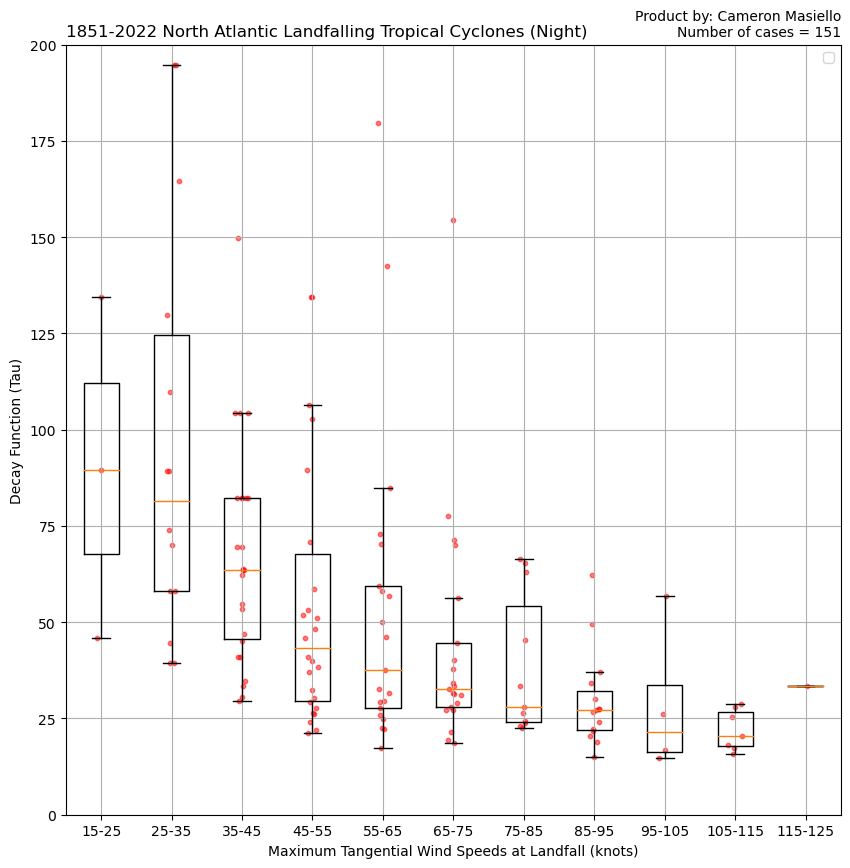

In [33]:
# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(all_v_pos_night, all_t_pos_night)

# Define the bin width
bin_width = 10

# Calculate the number of bins based on the bin width
num_bins = int((max(all_v_pos_night) - min(all_v_pos_night)) / bin_width)

# Create bin ranges with increments of 10
bin_ranges = [min(all_v_pos_night) + i * bin_width for i in range(num_bins)]
bin_ranges.append(bin_ranges[-1] + bin_width)

# Assuming all_v_pos_day and all_t_pos_day are NumPy arrays
all_v_pos_night = np.array(all_v_pos_night)
all_t_pos_night = np.array(all_t_pos_night)

# Initialize an empty list to store the data within each bin
bin_data = []

# Calculate the data within each bin
for i in range(num_bins): 
    mask = (all_v_pos_night > bin_ranges[i]) & (all_v_pos_night <= bin_ranges[i+1])
    bin_values = [all_t_pos_night[j] for j in range(len(mask)) if mask[j]]
    bin_data.append(bin_values)

# Create a box and whisker plot
fig = plt.figure(figsize=(10, 10))

# Plot the box and whisker plots
boxplot = plt.boxplot(bin_data, labels=[f'{bin_ranges[i]:.0f}-{bin_ranges[i+1]:.0f}' for i in range(num_bins)], showfliers=False)

# Overlay individual data points
for i, data in enumerate(bin_data, start=1):
    # Add a random jitter in the x-direction
    jitter = 0.05 * np.random.randn(len(data))
    plt.scatter(jitter + i, data, alpha=0.5, marker='o', color='red', s=10)

plt.grid() 
plt.legend()
plt.ylim(0,200)

plt.xlabel('Maximum Tangential Wind Speeds at Landfall (knots)')
plt.ylabel('Decay Function (Tau)')
plt.title('1851-2022 North Atlantic Landfalling Tropical Cyclones (Night)', fontsize=12, loc='left')
plt.title(f'Product by: Cameron Masiello\nNumber of cases = {len(all_v_pos_night)}', fontsize=10, loc='right')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


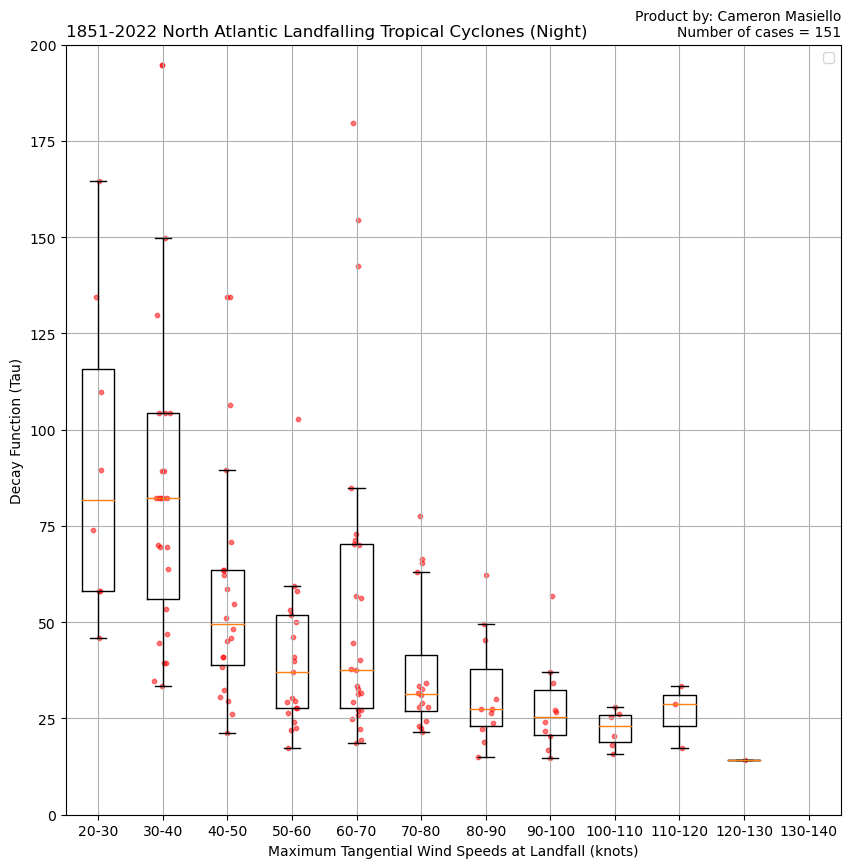

In [34]:
# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(all_v_pos_night, all_t_pos_night)

# Define the fixed range and bin width
min_bin = 20
max_bin = 140
bin_width = 10

# Calculate the number of bins based on the fixed range and bin width
num_bins = (max_bin - min_bin) // bin_width

# Create fixed bin ranges with increments of bin_width
bin_ranges = [min_bin + i * bin_width for i in range(num_bins + 1)]

# Convert lists to NumPy arrays
all_v_pos_night = np.array(all_v_pos_night)
all_t_pos_night = np.array(all_t_pos_night)

# Initialize an empty list to store the data within each bin
bin_data = []

# Calculate the data within each bin
for i in range(num_bins): 
    mask = (all_v_pos_night > bin_ranges[i]) & (all_v_pos_night <= bin_ranges[i+1])
    bin_values = all_t_pos_night[mask]
    bin_data.append(bin_values)

# Create a box and whisker plot
fig = plt.figure(figsize=(10, 10))

# Plot the box and whisker plots
boxplot = plt.boxplot(bin_data, labels=[f'{bin_ranges[i]}-{bin_ranges[i+1]}' for i in range(num_bins)], showfliers=False)

# Overlay individual data points
for i, data in enumerate(bin_data, start=1):
    jitter = 0.05 * np.random.randn(len(data))
    plt.scatter(jitter + i, data, alpha=0.5, marker='o', color='red', s=10)

plt.grid()
plt.legend()
plt.ylim(0, 200)

plt.xlabel('Maximum Tangential Wind Speeds at Landfall (knots)')
plt.ylabel('Decay Function (Tau)')
plt.title('1851-2022 North Atlantic Landfalling Tropical Cyclones (Night)', fontsize=12, loc='left')
plt.title(f'Product by: Cameron Masiello\nNumber of cases = {len(all_v_pos_night)}', fontsize=10, loc='right')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


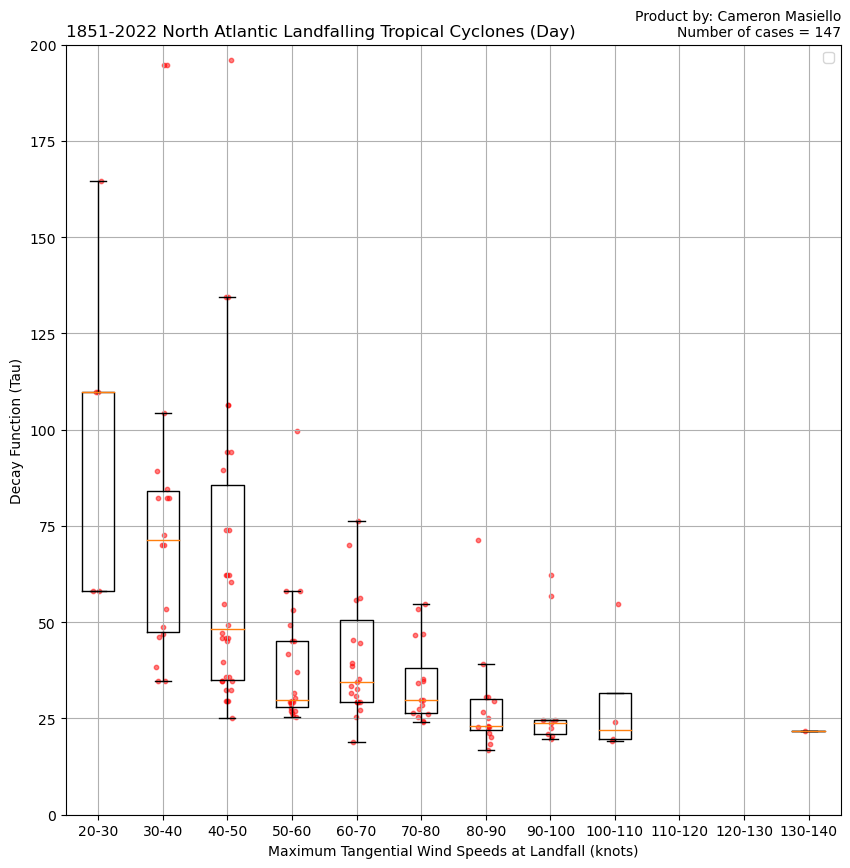

In [35]:
# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(all_v_pos_day, all_t_pos_day)

# Define the fixed range and bin width
min_bin = 20
max_bin = 140
bin_width = 10

# Calculate the number of bins based on the fixed range and bin width
num_bins = (max_bin - min_bin) // bin_width

# Create fixed bin ranges with increments of bin_width
bin_ranges = [min_bin + i * bin_width for i in range(num_bins + 1)]

# Convert lists to NumPy arrays
all_v_pos_day = np.array(all_v_pos_day)
all_t_pos_day = np.array(all_t_pos_day)

# Initialize an empty list to store the data within each bin
bin_data = []

# Calculate the data within each bin
for i in range(num_bins): 
    mask = (all_v_pos_day > bin_ranges[i]) & (all_v_pos_day <= bin_ranges[i+1])
    bin_values = all_t_pos_day[mask]
    bin_data.append(bin_values)

# Create a box and whisker plot
fig = plt.figure(figsize=(10, 10))

# Plot the box and whisker plots
boxplot = plt.boxplot(bin_data, labels=[f'{bin_ranges[i]}-{bin_ranges[i+1]}' for i in range(num_bins)], showfliers=False)

# Overlay individual data points
for i, data in enumerate(bin_data, start=1):
    jitter = 0.05 * np.random.randn(len(data))
    plt.scatter(jitter + i, data, alpha=0.5, marker='o', color='red', s=10)

plt.grid()
plt.legend()
plt.ylim(0, 200)

plt.xlabel('Maximum Tangential Wind Speeds at Landfall (knots)')
plt.ylabel('Decay Function (Tau)')
plt.title('1851-2022 North Atlantic Landfalling Tropical Cyclones (Day)', fontsize=12, loc='left')
plt.title(f'Product by: Cameron Masiello\nNumber of cases = {len(all_v_pos_day)}', fontsize=10, loc='right')

plt.show()

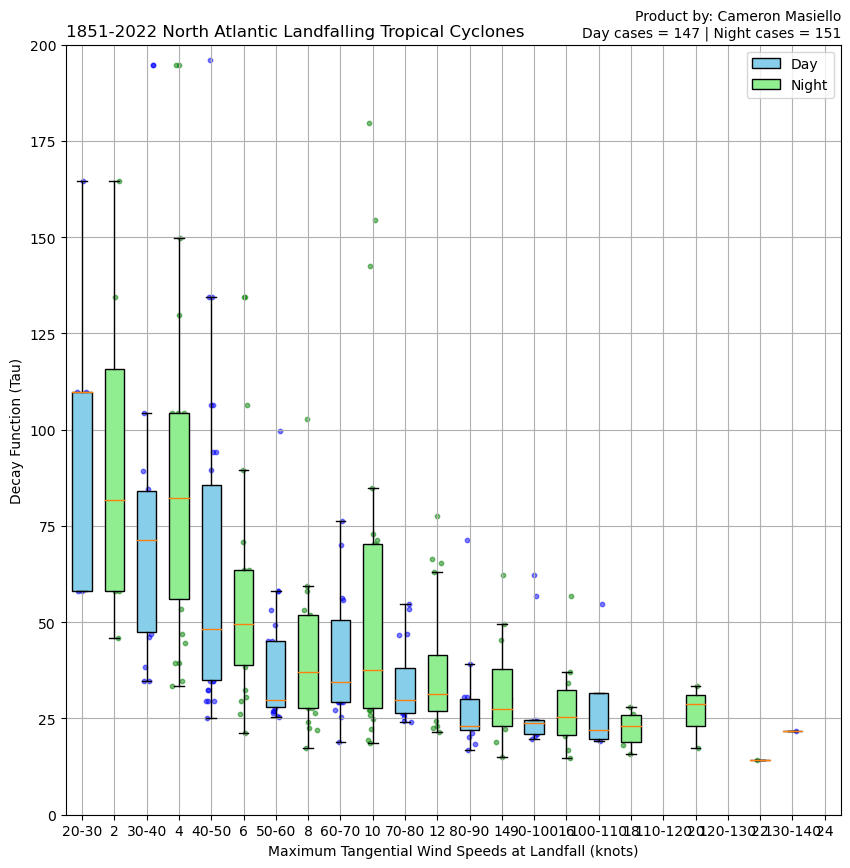

In [36]:
# Assuming all_v_pos_day, all_t_pos_day, all_v_pos_night, all_t_pos_night are defined
# Define the fixed range and bin width
min_bin = 20
max_bin = 140
bin_width = 10

# Calculate the number of bins based on the fixed range and bin width
num_bins = (max_bin - min_bin) // bin_width

# Create fixed bin ranges with increments of bin_width
bin_ranges = [min_bin + i * bin_width for i in range(num_bins + 1)]

# Define a function to calculate bin data
def calculate_bin_data(all_v_pos, all_t_pos):
    # Convert lists to NumPy arrays
    all_v_pos = np.array(all_v_pos)
    all_t_pos = np.array(all_t_pos)

    # Initialize an empty list to store the data within each bin
    bin_data = []

    # Calculate the data within each bin
    for i in range(num_bins):
        mask = (all_v_pos > bin_ranges[i]) & (all_v_pos <= bin_ranges[i+1])
        bin_values = all_t_pos[mask]
        bin_data.append(bin_values)
    
    return bin_data

# Calculate bin data for both day and night
bin_data_day = calculate_bin_data(all_v_pos_day, all_t_pos_day)
bin_data_night = calculate_bin_data(all_v_pos_night, all_t_pos_night)

# Create a box and whisker plot
fig = plt.figure(figsize=(10, 10))

# Set positions for each set of boxplots
positions_day = np.array(range(1, num_bins * 2, 2))
positions_night = positions_day + 1

# Plot the box and whisker plots for day
boxplot_day = plt.boxplot(bin_data_day, positions=positions_day, widths=0.6, patch_artist=True, 
                          boxprops=dict(facecolor='skyblue'), showfliers=False, labels=[
                              f'{bin_ranges[i]}-{bin_ranges[i+1]}' for i in range(num_bins)])

# Plot the box and whisker plots for night
boxplot_night = plt.boxplot(bin_data_night, positions=positions_night, widths=0.6, patch_artist=True, 
                            boxprops=dict(facecolor='lightgreen'), showfliers=False)

# Overlay individual data points for day and night
for i, data in enumerate(bin_data_day, start=1):
    jitter = 0.1 * np.random.randn(len(data))
    plt.scatter(jitter + positions_day[i-1], data, alpha=0.5, marker='o', color='blue', s=10)

for i, data in enumerate(bin_data_night, start=1):
    jitter = 0.1 * np.random.randn(len(data))
    plt.scatter(jitter + positions_night[i-1], data, alpha=0.5, marker='o', color='green', s=10)

# Customize the plot
plt.grid()
plt.ylim(0, 200)

plt.xlabel('Maximum Tangential Wind Speeds at Landfall (knots)')
plt.ylabel('Decay Function (Tau)')
plt.title('1851-2022 North Atlantic Landfalling Tropical Cyclones', fontsize=12, loc='left')
plt.title(f'Product by: Cameron Masiello\nDay cases = {len(all_v_pos_day)} | Night cases = {len(all_v_pos_night)}', fontsize=10, loc='right')
plt.legend([boxplot_day["boxes"][0], boxplot_night["boxes"][0]], ['Day', 'Night'], loc='upper right')

plt.show()

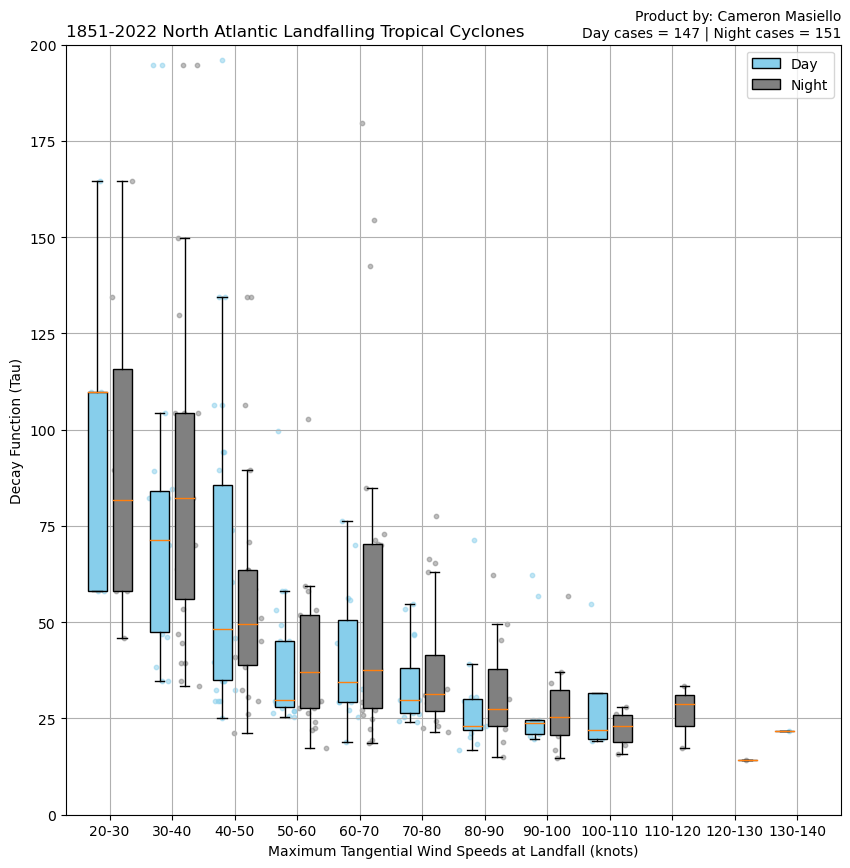

In [42]:
# Assuming all_v_pos_day, all_t_pos_day, all_v_pos_night, all_t_pos_night are defined
# Define the fixed range and bin width
min_bin = 20
max_bin = 140
bin_width = 10

# Calculate the number of bins based on the fixed range and bin width
num_bins = (max_bin - min_bin) // bin_width

# Create fixed bin ranges with increments of bin_width
bin_ranges = [min_bin + i * bin_width for i in range(num_bins + 1)]

# Define a function to calculate bin data
def calculate_bin_data(all_v_pos, all_t_pos):
    # Convert lists to NumPy arrays
    all_v_pos = np.array(all_v_pos)
    all_t_pos = np.array(all_t_pos)

    # Initialize an empty list to store the data within each bin
    bin_data = []

    # Calculate the data within each bin
    for i in range(num_bins):
        mask = (all_v_pos > bin_ranges[i]) & (all_v_pos <= bin_ranges[i+1])
        bin_values = all_t_pos[mask]
        bin_data.append(bin_values)
    
    return bin_data

# Calculate bin data for both day and night
bin_data_day = calculate_bin_data(all_v_pos_day, all_t_pos_day)
bin_data_night = calculate_bin_data(all_v_pos_night, all_t_pos_night)

# Create a box and whisker plot
fig = plt.figure(figsize=(10, 10))

# Calculate the central positions for each bin label
central_positions = np.arange(len(bin_ranges) - 1) + 0.5

# Offset the day and night boxplots slightly from the central positions
offset = 0.2  # This determines how far the boxplots are offset from the center
positions_day = central_positions - offset
positions_night = central_positions + offset

# Plot the box and whisker plots for day
boxplot_day = plt.boxplot(bin_data_day, positions=positions_day, widths=0.3, patch_artist=True,
                          boxprops=dict(facecolor='skyblue'), showfliers=False)

# Plot the box and whisker plots for night
boxplot_night = plt.boxplot(bin_data_night, positions=positions_night, widths=0.3, patch_artist=True,
                            boxprops=dict(facecolor='grey'), showfliers=False)

# Overlay individual data points for day and night
for i, data in enumerate(bin_data_day, start=1):
    jitter = 0.1 * np.random.randn(len(data))
    plt.scatter(jitter + positions_day[i-1], data, alpha=0.5, marker='o', color='skyblue', s=10)

for i, data in enumerate(bin_data_night, start=1):
    jitter = 0.1 * np.random.randn(len(data))
    plt.scatter(jitter + positions_night[i-1], data, alpha=0.5, marker='o', color='grey', s=10)

# Set the x-ticks to be at the central positions with the bin labels
plt.xticks(central_positions, [f'{bin_ranges[i]}-{bin_ranges[i+1]}' for i in range(num_bins)])

# Customize the plot
plt.grid()
plt.ylim(0, 200)

plt.xlabel('Maximum Tangential Wind Speeds at Landfall (knots)')
plt.ylabel('Decay Function (Tau)')
plt.title('1851-2022 North Atlantic Landfalling Tropical Cyclones', fontsize=12, loc='left')
plt.title(f'Product by: Cameron Masiello\nDay cases = {len(all_v_pos_day)} | Night cases = {len(all_v_pos_night)}', fontsize=10, loc='right')
plt.legend([boxplot_day["boxes"][0], boxplot_night["boxes"][0]], ['Day', 'Night'], loc='upper right')

plt.show()